In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3548329503568598267
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14417788928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 397329192161168991
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import cv2
from pathlib import Path
import keras
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image
import seaborn as sns
from tensorflow.keras.models import load_model
import time
from matplotlib import gridspec


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
batch_size_train = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                             rotation_range=40,width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.15)
test_datagen = ImageDataGenerator(rescale= 1/255.)
train_CON = train_datagen.flow_from_directory('/content/drive/MyDrive/kaggle_all/train', target_size=(299,299),
                                            batch_size=batch_size_train,
                                            class_mode="categorical", subset='training')
val_CON = train_datagen.flow_from_directory('/content/drive/MyDrive/kaggle_all/train', target_size=(299,299),
                                            batch_size=batch_size_train,
                                            class_mode="categorical", subset='validation')
test_CON = test_datagen.flow_from_directory('/content/drive/MyDrive/kaggle_all/test', target_size=(299,299),
                                            batch_size=batch_size_train,
                                            class_mode="categorical",shuffle=False)

class_map = train_CON.class_indices

Found 13660 images belonging to 2 classes.
Found 2409 images belonging to 2 classes.
Found 2838 images belonging to 2 classes.


In [ ]:
#load model
path_model = r'/content/drive/MyDrive/model/model_Xception_kaggle.h5'
print('Loading model from Google Drive')
model = load_model(path_model)
print('Load model Sucessfull!')

Loading model from Google Drive
Load model Sucessfull!


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 64)                131136    
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 20,992,746
Trainable params: 20,938,218
Non-trainable params: 54,528
_____________________________________

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

img_width, img_height = 224, 224

def labels_confusion_matrix():
    folder_path="/content/drive/MyDrive/kaggle_all/test/"
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):
            
            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(img_height, img_width))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed = img_processed/255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):

    
    #cm_plot_labels = [i for i in range(20)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,class_map.keys(),class_map.keys())
    sns.set(font_scale=1.1) # for label size
    plt.figure(figsize = (12,9))
    s=sns.heatmap(df_cm, annot=True,cmap = 'viridis',fmt='g') # font size
    bottom,top=s.get_ylim()
    s.set_ylim(bottom+0.6,top-0.6)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

1/1 [==============================] - 0s 27ms/step


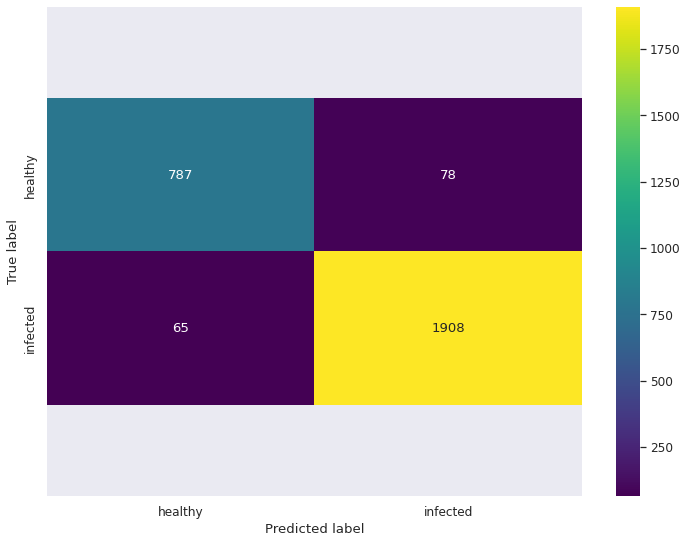

In [ ]:
class_map = train_CON.class_indices

y_true,y_pred=labels_confusion_matrix()
print_confusion_matrix(y_true,y_pred)

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(test_CON)
pred  = np.argmax(pred, axis=1)
y_test  = test_CON.labels
print(classification_report(y_test, pred))

89/89 [==============================] - 38s 401ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       865
           1       0.96      0.98      0.97      1973

    accuracy                           0.96      2838
   macro avg       0.95      0.95      0.95      2838
weighted avg       0.96      0.96      0.96      2838



In [ ]:
test_CON1 = test_datagen.flow_from_directory("/content/drive/MyDrive/TRAIN_PROJECT/CONSENSUS_ALL/test/", target_size=(299,299),
                                            batch_size=batch_size_train,
                                            class_mode="categorical",shuffle=False)

Found 505 images belonging to 2 classes.


In [ ]:
test_CON2 = test_datagen.flow_from_directory("/content/drive/MyDrive/test_vote_data/", target_size=(299,299),
                                            batch_size=batch_size_train,
                                            class_mode="categorical",shuffle=False)

Found 104 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(test_CON1)
pred  = np.argmax(pred, axis=1)
y_test  = test_CON1.labels
print(classification_report(y_test, pred))

16/16 [==============================] - 210s 14s/step
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       117
           1       0.99      0.89      0.94       388

    accuracy                           0.91       505
   macro avg       0.87      0.94      0.89       505
weighted avg       0.93      0.91      0.92       505



In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(test_CON2)
pred  = np.argmax(pred, axis=1)
y_test  = test_CON2.labels
print(classification_report(y_test, pred))

4/4 [==============================] - 25s 8s/step
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        64
           1       0.86      0.75      0.80        40

    accuracy                           0.86       104
   macro avg       0.86      0.84      0.84       104
weighted avg       0.86      0.86      0.85       104



In [ ]:
#load model
path_model1 = r'/content/drive/MyDrive/model/model_Xception_addkaggle.h5'
print('Loading model from Google Drive')
model1 = load_model(path_model1)
print('Load model Sucessfull!')

Loading model from Google Drive
Load model Sucessfull!


In [ ]:
scores = model1.evaluate_generator(test_CON1)
print("Test Accuracy: {:.3f}".format(scores[1]))

<ipython-input-20-7d72c9f5e1fa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model1.evaluate_generator(test_CON1)


Test Accuracy: 0.943


In [ ]:
category={
    0: ['FALSE'], 1: ['TRUE']}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    print(prediction)
    
    plt.title("Prediction - {}".format(category[index][0]))
    plt.imshow(img_array)
    plt.axis('off')

In [ ]:
category = {
    0 : ['FALSE'], 1 : ['TRUE'] 
}
path_file = r'/content/drive/MyDrive/leaf/'
path = os.listdir(path_file)
#print(path)
new = [os.path.join(path_file, path[i]) for i in range(len(path))]
#print(new)

img_ = [image.load_img(new[i], target_size=(299,299)) for i in range(len(new))]
img_array = [image.img_to_array(img_[i]) for i in range(len(img_))]
img_process = [np.expand_dims(img_array[i], axis=0) for i in range(len(img_array))]
img_process = [(img_process[i]/255.0) for i in range(len(img_process))]

prediction = [model.predict(img_process[i]) for i in range(len(img_process))]
index = [np.argmax(prediction[i]) for i in range(len(prediction))]



KeyboardInterrupt: ignored

In [ ]:
path_in = r'/content/drive/MyDrive/model/model_Xception_addkaggle.h5'
model1 = load_model(path_in)
print('load succesfullllll')

load succesfullllll


1/1 [==============================] - 0s 312ms/step
[[0.94668823 0.05331181]]
Procesing time : 0.8026773929595947 sec


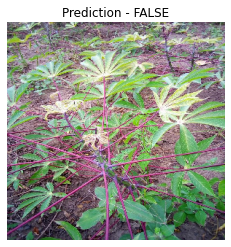

In [ ]:
start = time.time()
predict_image('/content/drive/MyDrive/CGM/2323936.jpg', model)
end = time.time()
print(f"Procesing time : {end-start} sec")


In [ ]:
category = {
    0 : ['FALSE'], 1 : ['TRUE'] 
}
path_file = r'/content/drive/MyDrive/casv/healthy/'
path = os.listdir(path_file)
#print(path)
new = [os.path.join(path_file, path[i]) for i in range(len(path))]
#print(new)

img_ = [image.load_img(new[i], target_size=(299,299)) for i in range(len(new))]
img_array = [image.img_to_array(img_[i]) for i in range(len(img_))]
img_process = [np.expand_dims(img_array[i], axis=0) for i in range(len(img_array))]
img_process = [(img_process[i]/255.0) for i in range(len(img_process))]

prediction = [model.predict(img_process[i]) for i in range(len(img_process))]
index = [np.argmax(prediction[i]) for i in range(len(prediction))]


In [ ]:
# 0 Healthy 1 infected
dic = {'predict': index, 'flie_name': path}
df = pd.DataFrame(dic)
df

,predict,flie_name
0,0,cassavaleaves7.jpeg
1,0,cassavaleaves10.jpeg
2,1,cassavaleaves9.jpeg
3,0,cassavaleaves13.png
4,0,cassavaleaves16.jpeg
...,...,...
139,0,healthycassavaleaf199.jpeg
140,1,healthycassavaleaf212.jpeg
141,0,healthycassavaleaf211.jpeg
142,1,healthycassavaleaf217.jpeg


In [ ]:
#show false negative
df_edit = df.copy()
df_edit[df['predict']==1]

,predict,flie_name
2,1,cassavaleaves9.jpeg
11,1,cassavaleaves33.png
25,1,cassavaleaves78.jpeg
31,1,cassavaleaves107.jpeg
41,1,cassavaleaves135.jpeg
54,1,cassavaleaves187.jpeg
67,1,cassavaleaves253.jpeg
79,1,cassavaleaves305.jpeg
90,1,healthycassavaleaf0.png
106,1,healthycassavaleaf50.jpeg
